## Lunar Lander - State

### Imports 

In [118]:
from IPython.display import display, HTML, Image

from sklearn.base import BaseEstimator, ClassifierMixin

import pandas as pd
import numpy as np

from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn import neighbors
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import ensemble
from sklearn import tree
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from pandas.plotting import scatter_matrix
from sklearn import datasets, svm, linear_model, neighbors, svm
import itertools
import sklearn.cross_validation as cv
plt.style.use('classic')
SEED = 222
np.random.seed(SEED)
from sklearn.ensemble import AdaBoostClassifier

import keras
from keras.models import Sequential
from keras.layers import Input, GlobalAveragePooling2D, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop, adam
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical

from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt


%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Load & Partition State Data

In [119]:
dataset = pd.read_csv('state_vectors_2018-04-09-18-25-26.csv')
display(dataset.head())

,step,pos_x,pos_y,vel_x,vel_y,ship_lander_angle,ship_lander_angular_vel,leg_1_ground_contact,leg_2_ground_contact,action
0,0,-0.004053,0.937387,-0.410560,-0.215127,0.004703,0.092998,0.0,0.0,3
1,1,-0.008040,0.933774,-0.401600,-0.240878,0.007613,0.058204,0.0,0.0,3
2,2,-0.011951,0.929763,-0.392188,-0.267401,0.008632,0.020372,0.0,0.0,3
3,3,-0.015796,0.925359,-0.383742,-0.293582,0.007955,-0.013536,0.0,0.0,3
4,4,-0.019576,0.920563,-0.375744,-0.319748,0.005674,-0.045625,0.0,0.0,3


In [120]:
X = dataset[['pos_x',
 'pos_y',  
 'vel_x',
 'vel_y',
 'ship_lander_angle',
 'ship_lander_angular_vel',
 'leg_1_ground_contact',
 'leg_2_ground_contact']]
y = dataset["action"]

# Splitting into train, test and validation set
X_train_plus_valid, X_test, y_train_plus_valid, y_test \
    = train_test_split(X, y, random_state=0, \
                                    train_size = 0.7, shuffle = False)

X_train, X_valid, y_train, y_valid \
    = train_test_split(X_train_plus_valid, \
                                        y_train_plus_valid, \
                                        random_state=0, \
                                        train_size = 0.5/0.7, shuffle = False)
    
y_train_plus_valid_ann = to_categorical(y_train_plus_valid,4)

### Classifier 1 - Decision Tree

<b>Simple Decision Tree & Evaluation</b>

In [121]:
# Fitting a simple decision tree
decisiontree = tree.DecisionTreeClassifier(criterion="entropy", max_depth=10, min_samples_split=20)

decisiontree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [122]:
# Predicting on the simple decision tree
predict = decisiontree.predict(X_valid)

# Print performance details for the simple tree
accuracy = metrics.accuracy_score(predict,y_valid)
print ("Accuracy with label:" +str(accuracy))
print("Accuracy: " +  str(accuracy))

# Print classification report
print(metrics.classification_report(y_valid, predict))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), predict, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy with label:0.806572172633839
Accuracy: 0.806572172633839
             precision    recall  f1-score   support

          0       0.85      0.80      0.82     23544
          1       0.95      0.39      0.55      1857
          2       0.77      0.88      0.82     23113
          3       0.92      0.34      0.50      1789

avg / total       0.82      0.81      0.80     50303

Confusion Matrix


Predicted,0,1,2,3,All
True,,,,,
0,18804,16,4710,14,23544
1,355,716,786,0,1857
2,2611,18,20445,39,23113
3,409,0,772,608,1789
All,22179,750,26713,661,50303


<b> Tuned Decision Tree & Evaluation</b>

In [123]:
# Parameter List
param_grid ={'criterion': ['gini', "entropy"], 'max_depth': list(range(5, 10, 20)), 'min_samples_split': [20,50] }

# Perform the Grid search
tuned_dt = GridSearchCV(tree.DecisionTreeClassifier(), param_grid, cv=2)
tuned_dt.fit(X_train_plus_valid, y_train_plus_valid)

# Print best parameter set
display(tuned_dt.best_params_)
display(tuned_dt.best_score_)

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 20}

0.7758125163298458

In [124]:
# Test the tuned tree
predict = tuned_dt.predict(X_test)

# Print performance details for the tuned tree
accuracy = metrics.accuracy_score(predict,y_test)
model_test_accuracy_compare = dict()
model_test_accuracy_compare["Tuned Decision Tree"] = accuracy
print ("Accuracy with label:" +str(accuracy))

# Print classification report
print(metrics.classification_report(y_test, predict))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(y_test, predict, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy with label:0.7740212579849974
             precision    recall  f1-score   support

          0       0.93      0.66      0.77     35282
          1       0.99      0.28      0.43      2876
          2       0.69      0.97      0.81     34754
          3       0.93      0.27      0.42      2542

avg / total       0.82      0.77      0.76     75454

Confusion Matrix


Predicted,0,1,2,3,All
True,,,,,
0,23265,9,11953,55,35282
1,463,800,1613,0,2876
2,1101,0,33653,0,34754
3,256,0,1601,685,2542
All,25085,809,48820,740,75454


### Classifier 2 - Random Forest Classifier

<b> Simple Random Forest Classifier & Evaluation </b>

In [125]:
# Fitting a simple random forest classifier
rfc = ensemble.RandomForestClassifier(n_estimators=100, min_samples_split=200)

rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=200,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [126]:
# Predicting on the simple random forest classifier
predict = rfc.predict(X_valid)

# Print performance details for the simple random forest classifier
accuracy = metrics.accuracy_score(y_valid, predict)
print("Accuracy: " +  str(accuracy))

# Print classification report
print(metrics.classification_report(y_valid, predict))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), predict, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.8348408643619665
             precision    recall  f1-score   support

          0       0.91      0.80      0.85     23544
          1       1.00      0.36      0.53      1857
          2       0.77      0.95      0.85     23113
          3       1.00      0.32      0.48      1789

avg / total       0.85      0.83      0.83     50303

Confusion Matrix


Predicted,0,1,2,3,All
True,,,,,
0,18727,0,4816,1,23544
1,362,670,825,0,1857
2,1082,0,22031,0,23113
3,362,0,860,567,1789
All,20533,670,28532,568,50303


<b> Tuned Random Forest Classifier & Evaluation </b>

In [127]:
# parameter list
param_grid = [{'n_estimators': list(range(50, 100, 150)), 'min_samples_split': [10, 20, 30]}]

# Perform the grid search
tuned_rfc = GridSearchCV(ensemble.RandomForestClassifier(), param_grid, cv=2)
tuned_rfc.fit(X_train_plus_valid, y_train_plus_valid)

# Print best parameter set
print(tuned_rfc.best_params_)
print(tuned_rfc.best_score_)

{'n_estimators': 50, 'min_samples_split': 10}
0.8743311863136012


In [128]:
# Predicting on the tuned random forest classifier
predict = tuned_rfc.predict(X_test)

# Print Performance details for the tuned random forest classifier
accuracy = metrics.accuracy_score(predict,y_test)
model_test_accuracy_compare["Tuned Random Forest Tree"] = accuracy
print ("Accuracy with label:" +str(accuracy))

# Print Classification Report
print(metrics.classification_report(y_test, predict))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(y_test, predict, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy with label:0.8870040024385718
             precision    recall  f1-score   support

          0       0.92      0.88      0.90     35282
          1       0.95      0.46      0.62      2876
          2       0.85      0.96      0.90     34754
          3       0.93      0.43      0.59      2542

avg / total       0.89      0.89      0.88     75454

Confusion Matrix


Predicted,0,1,2,3,All
True,,,,,
0,31125,37,4077,43,35282
1,634,1313,929,0,2876
2,1276,34,33401,43,34754
3,615,0,838,1089,2542
All,33650,1384,39245,1175,75454


### Classifier 3 - ANN 

<b> Simple ANN Model & Evaluation </b>

In [129]:
# Define a simple ANN model
model = Sequential()

model.add(Dense(input_dim=8, units=32))
model.add(Activation("relu"))

model.add(Dense(units=16))
model.add(Activation("relu"))

model.add(Dense(units=8))
model.add(Activation("relu"))

model.add(Dense(units=4))
model.add(Activation("softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_321 (Dense)            (None, 32)                288       
_________________________________________________________________
activation_321 (Activation)  (None, 32)                0         
_________________________________________________________________
dense_322 (Dense)            (None, 16)                528       
_________________________________________________________________
activation_322 (Activation)  (None, 16)                0         
_________________________________________________________________
dense_323 (Dense)            (None, 8)                 136       
_________________________________________________________________
activation_323 (Activation)  (None, 8)                 0         
_________________________________________________________________
dense_324 (Dense)            (None, 4)                 36        
__________

In [130]:
# Compile the simple ANN model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [131]:
# Train the simple ANN model
epochs = 30

batch_size = 128

history = model.fit(X_train_plus_valid, y_train_plus_valid_ann, batch_size=batch_size, epochs=epochs, validation_split=0.25, verbose=1, shuffle=True,)

Train on 132043 samples, validate on 44015 samples
Epoch 1/30
132043/132043 [==============================] - 7s 56us/step - loss: 0.2966 - acc: 0.8669 - val_loss: 0.2575 - val_acc: 0.9007
Epoch 2/30
132043/132043 [==============================] - 4s 32us/step - loss: 0.1930 - acc: 0.9267 - val_loss: 0.1691 - val_acc: 0.9426
Epoch 3/30
132043/132043 [==============================] - 5s 36us/step - loss: 0.1351 - acc: 0.9515 - val_loss: 0.1249 - val_acc: 0.9581
Epoch 4/30
132043/132043 [==============================] - 4s 34us/step - loss: 0.1056 - acc: 0.9616 - val_loss: 0.1117 - val_acc: 0.9623
Epoch 5/30
132043/132043 [==============================] - 4s 33us/step - loss: 0.0930 - acc: 0.9658 - val_loss: 0.1042 - val_acc: 0.9640
Epoch 6/30
132043/132043 [==============================] - 5s 38us/step - loss: 0.0854 - acc: 0.9683 - val_loss: 0.0943 - val_acc: 0.9700
Epoch 7/30
132043/132043 [==============================] - 5s 39us/step - loss: 0.0790 - acc: 0.9713 - val_loss: 0

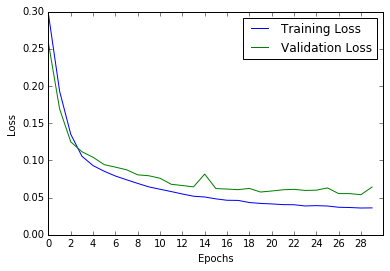

In [132]:
# Plotting evolution of loss for the simple ANN model
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')

plt.xticks(range(0,epochs)[0::2])
plt.legend()

plt.show()

In [133]:
# Predicting on the simple ANN model
predict = model.predict_classes(X_test)

# Print performance details for the simple ANN model
accuracy = metrics.accuracy_score(y_test, predict)
print("Accuracy: " +  str(accuracy))

# Print classification report
print(metrics.classification_report(y_test, predict))

# Print confusion matrix
print("Confusion Matrix")
print(metrics.confusion_matrix(y_test, pred))

Accuracy: 0.9588093407904154
             precision    recall  f1-score   support

          0       0.95      0.98      0.96     35282
          1       0.95      0.85      0.90      2876
          2       0.98      0.95      0.96     34754
          3       0.86      0.93      0.89      2542

avg / total       0.96      0.96      0.96     75454

Confusion Matrix
[[34122   102   966    92]
 [  177  2394   305     0]
 [   89    34 34561    70]
 [  162     0    96  2284]]


<b> Tuned ANN Model & Evaluation </b>

In [134]:
# Function to create & compile the tuned ANN model
def ann_model(layer1=32, layer2=16, layer3=8, layer4=4):
    model = Sequential()
    
    model.add(Dense(input_dim=8, units=layer1))
    model.add(Activation("relu"))          
    
    model.add(Dense(units=layer2))
    model.add(Activation("relu"))
    
    model.add(Dense(units=layer3))
    model.add(Activation("relu"))
    
    model.add(Dense(units=layer4))
    model.add(Activation("softmax"))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Define the model
model = KerasClassifier(build_fn=ann_model, epochs=30, batch_size=128, verbose=0)

# Create parameter set
layer1 = [32,64]
layer2 = [16,32]
layer3 = [8,16]
layer4 = [4]

param = dict(layer1=layer1, layer2=layer2, layer3=layer3, layer4=layer4)

# Perform grid search
tuned_ann = GridSearchCV(estimator=model, param_grid=param, cv=2, verbose=1)

# Train the tuned model
tuned_ann.fit(X_train_plus_valid, y_train_plus_valid_ann)

# Print the best set of parameters

print(clf.best_score_)
print(clf.best_params_)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 18.7min finished


0.9855445364622842
{'layer2': 16, 'layer1': 64, 'layer3': 8, 'layer4': 4}


In [135]:
# Apply the best set of parameter to create the tuned ANN model 
model = Sequential()

model.add(Dense(input_dim=8, units=64))
model.add(Activation("relu"))

model.add(Dense(units=16))
model.add(Activation("relu"))

model.add(Dense(units=8))
model.add(Activation("relu"))

model.add(Dense(units=4))
model.add(Activation("softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_393 (Dense)            (None, 64)                576       
_________________________________________________________________
activation_393 (Activation)  (None, 64)                0         
_________________________________________________________________
dense_394 (Dense)            (None, 16)                1040      
_________________________________________________________________
activation_394 (Activation)  (None, 16)                0         
_________________________________________________________________
dense_395 (Dense)            (None, 8)                 136       
_________________________________________________________________
activation_395 (Activation)  (None, 8)                 0         
_________________________________________________________________
dense_396 (Dense)            (None, 4)                 36        
__________

In [136]:
# Compile the tuned ANN model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [137]:
# Train the tuned ANN model
epochs = 30

batch_size = 128

history = model.fit(X_train_plus_valid, y_train_plus_valid_ann, batch_size=batch_size, epochs=epochs, validation_split=0.25, verbose=1, shuffle=True,)

Train on 132043 samples, validate on 44015 samples
Epoch 1/30
132043/132043 [==============================] - 9s 66us/step - loss: 0.2663 - acc: 0.8842 - val_loss: 0.2038 - val_acc: 0.9216
Epoch 2/30
132043/132043 [==============================] - 5s 40us/step - loss: 0.1469 - acc: 0.9460 - val_loss: 0.1460 - val_acc: 0.9524
Epoch 3/30
132043/132043 [==============================] - 5s 36us/step - loss: 0.1055 - acc: 0.9617 - val_loss: 0.1173 - val_acc: 0.9636
Epoch 4/30
132043/132043 [==============================] - 4s 34us/step - loss: 0.0878 - acc: 0.9688 - val_loss: 0.1026 - val_acc: 0.9676
Epoch 5/30
132043/132043 [==============================] - 4s 34us/step - loss: 0.0774 - acc: 0.9727 - val_loss: 0.0948 - val_acc: 0.9747
Epoch 6/30
132043/132043 [==============================] - 5s 39us/step - loss: 0.0688 - acc: 0.9755 - val_loss: 0.0971 - val_acc: 0.9676
Epoch 7/30
132043/132043 [==============================] - 5s 40us/step - loss: 0.0621 - acc: 0.9782 - val_loss: 0

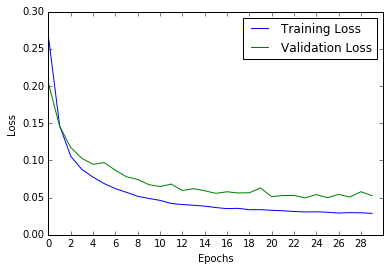

In [138]:
# Plotting the evolution of loss for the Tuned ANN Model 
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')

plt.xticks(range(0,epochs)[0::2])
plt.legend()

plt.show()

In [139]:
# Predict on the tuned ANN model
predict = model.predict_classes(X_test)

# Print performance details for the tuned ANN model
accuracy = metrics.accuracy_score(y_test, predict)
model_test_accuracy_compare["Tuned ANN"] = accuracy
print("Accuracy: " +  str(accuracy))

# Print classification report
print(metrics.classification_report(y_test, predict))

# Print confusion matrix
print("Confusion Matrix")
print(metrics.confusion_matrix(y_test, predict))

Accuracy: 0.9662443342963924
             precision    recall  f1-score   support

          0       0.95      0.99      0.97     35282
          1       0.97      0.89      0.93      2876
          2       0.98      0.95      0.97     34754
          3       0.91      0.92      0.92      2542

avg / total       0.97      0.97      0.97     75454

Confusion Matrix
[[34827    42   342    71]
 [  166  2565   145     0]
 [ 1380    40 33174   160]
 [  143     0    58  2341]]


### Classifier 4 - SuperLearner 

<b> Simple SuperLerner Classifier & Evaluation </b>

In [140]:
#Super Learner Class
class SuperLearnerClassifier(BaseEstimator,ClassifierMixin):
    
    def __init__(self, baseModels= None, stackModel=None,predProba=False,useOriginalInput=False,cv_folds=2,K=2,global_stack=None):
        self.cv_folds=cv_folds
        self.baseModels=baseModels
        self.K=K
        self.stackModel=stackModel
        self.predProba=predProba
        self.useOriginalInput=useOriginalInput
        self.global_stack=global_stack
    #The fit method for the SuperLEarner    
    def fit(self,X,y):
        #Set of base learners 
        baseLearnerSet=set(self.baseModels)
        
        stacked_predictions_fit=[]
        #KFold for splitting the data
        kf = KFold(n_splits=5)
        for train,test in kf.split(X):
            X_train=np.array(X)[train]
            Y_train=np.array(y)[train]
            X_test = np.array(X)[test]
            Y_Test = np.array(y)[test]
            #Fitting the model using the train data
            for i,model in enumerate(self.baseModels):
                model.fit(X_train,Y_train)
            predicted_values=[]
            #making base models predict labels or probabilities based on the predProba flag
            for i,model in enumerate(self.baseModels):
                if self.predProba==False:
                    P=model.predict(X_test)
                else:
                    P=model.predict_proba(X_test)
                predicted_values.append(P.tolist())
            stacked_predictions_fit.extend(np.column_stack(predicted_values).tolist())
        #Stacking the X with the stacked predictions
        if self.useOriginalInput==True:
            stacked_predictions_fit = np.column_stack((X,stacked_predictions_fit))

        #Training the meta learner
        meta_tree= self.stackModel
        self.global_stack=stacked_predictions_fit
        meta_tree.fit(stacked_predictions_fit,y)
        self.stackModel=meta_tree
        #Fitting the base models using the whole dataset again
        print("Done")
        for i,model in enumerate(self.baseModels):
            model.fit(X,y)
            
        return self
    #predict method for the superLearner
    def predict(self,X):
        stacked_predictions_fit=[]
        predicted_values=[]
        for i,model in enumerate(self.baseModels):
            if self.predProba==False:
                P=model.predict(X)
            else:
                P=model.predict_proba(X)
            predicted_values.append(P.tolist())
        stacked_predictions_fit.extend(np.column_stack(predicted_values).tolist())
        if self.useOriginalInput==True:
            stacked_predictions_fit = np.column_stack((X,stacked_predictions_fit))
        #making the stackModel predict on the stacked predictions from the base learners (class label)
        final_Predictions=self.stackModel.predict(stacked_predictions_fit)
        return final_Predictions
    #predict proba method for the superLearner
    def predict_proba(self,X):
        stacked_predictions_fit=[]
        predicted_values=[]
        for i,model in enumerate(self.baseModels):
            if self.predProba==False:
                P=model.predict(X)
            else:
                P=model.predict_proba(X)
            predicted_values.append(P.tolist())
        stacked_predictions_fit.extend(np.column_stack(predicted_values).tolist())
        if self.useOriginalInput==True:
            stacked_predictions_fit = np.column_stack((X,stacked_predictions_fit))
        #making the trained stackModel predict on the stacked predictions of base learners (probability outputs)
        final_Predictions=self.stackModel.predict_proba(stacked_predictions_fit)
        return final_Predictions

        cArray=np.array(corrMatrix)
        mask = np.zeros_like(cArray)
        mask[np.triu_indices_from(mask)] = True
        with sns.axes_style("white"):
            ax = sns.heatmap(cArray, mask=mask, vmax=.3, square=True)
        
    #The function which shows the Accuracy,F1Score,Recall,Precision 
    def predictivePowerEnsemble(self,Xtest,YTest):
        for i,model in enumerate(self.baseModels):
            print("Predictive Power of Each of the base model- Model"+str(i+1))
            pr=model.predict(Xtest)
            a = metrics.accuracy_score(pr,YTest)
            f1=metrics.f1_score(pr,YTest,average='weighted')
            r=metrics.recall_score(pr,YTest,average='weighted')
            p=metrics.precision_score(pr,YTest,average='weighted')
            print("Accuracy"+str(a))
            print("F1-Measure"+str(f1))
            print("Recall"+str(r))
            print("Precision"+str(p))
                 
        return 
    #The function to print the confusion heatmap of the confusion matrices of the base learners
    def confusionHeatMap(self,Xtest,YTest):
        confusion_aggregate=[]
        labels=["Gaussian","KNN","Logistic Regression","DecisionTree","RandomForest"]
        for i,model in enumerate(self.baseModels):
            pr=model.predict(XTest)
            matrix=metrics.confusion_matrix(YTest,pr)
            confusion_aggregate.append(matrix)
            
        conf={
        1:{
            'matrix':confusion_aggregate[0],
            'title':labels[0]
        }, 
         2:{
            'matrix':confusion_aggregate[1],
            'title':labels[1]
        }, 
         3:{
            'matrix':confusion_aggregate[2],
            'title':labels[2]
        }, 
         4:{
            'matrix':confusion_aggregate[3],
            'title':labels[3]
        }, 
         5:{
            'matrix':confusion_aggregate[4],
            'title':labels[4]
        }, 
         6:{
            'matrix':confusion_aggregate[5],
            'title':labels[5]
        }, 
         7:{
            'matrix':confusion_aggregate[6],
            'title':labels[6]
        }
    }
        fix, ax = plt.subplots(figsize=(16, 12))
        plt.suptitle('Confusion Matrix of Various Classifiers')
        for ii, values in conf.items():
            print("inside")
            matrix = values['matrix']
            title = values['title']
            plt.subplot(3, 4, ii) # starts from 1
            plt.title(title);
            sns.heatmap(matrix, annot=True,  fmt='');
        plt.show()
            
            
        return 
    #function to print the scatter plot of the predictions
    def scatterPlotforPrediction(self):
        print("Scatter Plot showing the predictions plot")
        d =pd.DataFrame(self.global_stack)
        scatter_matrix(d)
        


In [141]:
# Define the base and stack models
knn = KNeighborsClassifier(n_neighbors=3)
lr = LogisticRegression(C=100)
nb = naive_bayes.GaussianNB()
dt = tree.DecisionTreeClassifier(criterion="entropy")
rf = RandomForestClassifier(n_estimators=10, max_features=3)

baseModels=[knn,lr,nb,dt,rf]

stackModel=tree.DecisionTreeClassifier(criterion="entropy")

# Define the simple superlearner
superlearner = SuperLearnerClassifier(baseModels,stackModel,predProba=False,useOriginalInput=False)

# Train the simple superlearner model
superlearner.fit(X_train, y_train)

Done


SuperLearnerClassifier(K=2,
            baseModels=[KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform'), LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, m... n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)],
            cv_folds=2,
            global_stack=[[3, 3, 3, 3, 3], [3, 3, 3, 3, 3], [3, 3, 3, 3, 3], [3, 3, 3, 3, 3], [3, 0, 3, 3, 3], [3, 0, 1, 3, 3], [0, 0, 1, 3, 3], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0...2, 2, 1, 2, 2], [2, 2, 1, 2, 2], [2, 2, 1, 0, 2], [0, 2, 1, 0, 2], [2, 2, 1, 0, 0], [2, 2, 1, 2, 2]],
            predProba=False,
            stackModel=DecisionTreeClassifier(class_weight=None, criterion='entropy',

In [142]:
# predicting on the simple superlearner model 
predict = superlearner.predict(X_valid)

# Print performance details of the simple superlearner model
accuracy = metrics.accuracy_score(predict,y_valid)
print("Accuracy:" +str(accuracy))

# Print Classification Report
print(metrics.classification_report(y_valid, predict))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(y_valid, predict, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy:0.893048128342246
             precision    recall  f1-score   support

          0       0.91      0.91      0.91     23544
          1       0.87      0.54      0.66      1857
          2       0.89      0.93      0.91     23113
          3       0.78      0.54      0.64      1789

avg / total       0.89      0.89      0.89     50303

Confusion Matrix


Predicted,0,1,2,3,All
True,,,,,
0,21368,78,1957,141,23544
1,435,998,417,7,1857
2,1329,72,21582,130,23113
3,395,0,419,975,1789
All,23527,1148,24375,1253,50303


<b> Tuned SuperLearner & Evaluation </b>

In [143]:
#Different stack classifiers
tr=tree.DecisionTreeClassifier(criterion="entropy")
lr = LogisticRegression(C=100)
listOfStackModels=[tr,lr]

#Different base classifiers
nb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=3)
lr = LogisticRegression(C=100)
dt = tree.DecisionTreeClassifier(criterion="entropy")
rf = RandomForestClassifier(n_estimators=10, max_features=3)

baseModelsList=[nb,knn,lr,dt,rf]
baseModelsList1=[nb,knn,dt,rf]
baseModelsList2=[nb,knn,lr,rf]

BList=[baseModelsList,baseModelsList1,baseModelsList2]

#To use labels or probabilities
predProbaList=[False]

#creating the param grid for the gridSearch
useOriginalInputList=[False]
param_grid=dict(baseModels=BList,stackModel=listOfStackModels,predProba=predProbaList,useOriginalInput=useOriginalInputList)

#Perform Grid Search
tuned_superlearner= GridSearchCV(SuperLearnerClassifier(),param_grid,cv=2,scoring='accuracy')
tuned_superlearner.fit(X_train_plus_valid,y_train_plus_valid)

#To view the results
print(tuned_superlearner.best_score_)
print(tuned_superlearner.best_params_)

Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
0.8895080030444512
{'predProba': False, 'stackModel': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), 'baseModels': [GaussianNB(priors=None), KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform'), LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), DecisionTreeClassifier(class_weight=None, criterion='ent

In [144]:
# Predicting on the tuned superlearner
predict = tuned_superlearner.predict(X_test)

# Print performance details for the tuned superlearner
accuracy = metrics.accuracy_score(predict,y_test)
model_test_accuracy_compare["Tuned SuperLearner"] = accuracy
print("Accuracy:" +str(accuracy))

# Print Classification Report
print(metrics.classification_report(y_test, predict))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(y_test, predict, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy:0.9044053330506003
             precision    recall  f1-score   support

          0       0.92      0.92      0.92     35282
          1       0.84      0.61      0.70      2876
          2       0.89      0.94      0.92     34754
          3       0.83      0.55      0.66      2542

avg / total       0.90      0.90      0.90     75454

Confusion Matrix


Predicted,0,1,2,3,All
True,,,,,
0,32284,178,2679,141,35282
1,518,1745,613,0,2876
2,1622,165,32819,148,34754
3,544,0,605,1393,2542
All,34968,2088,36716,1682,75454


### Compare the Performance of the Tuned Models to Find the Best Model

In [145]:
display(model_test_accuracy_compare)

{'Tuned ANN': 0.9662443342963924,
 'Tuned Decision Tree': 0.7740212579849974,
 'Tuned Random Forest Tree': 0.8870040024385718,
 'Tuned SuperLearner': 0.9044053330506003}

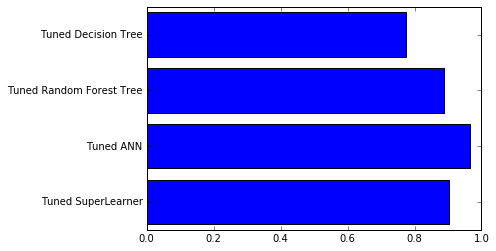

In [146]:
plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_test_accuracy_compare)), list(model_test_accuracy_compare.values()), align='center')
_ = plt.yticks(range(len(model_test_accuracy_compare)), list(model_test_accuracy_compare.keys()))

### Save the Best State Model

In [148]:
#Saving the model
filepath = "player_state.mod"
model.save(filepath)

In [149]:
model = keras.models.load_model("player_state.mod")